In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm,trange
import sklearn.metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

## First, let's load up our training data 

We've used a [modified version](https://www.kaggle.com/unkownhihi/deepfake) of the [deepfake-detection-challenge](https://www.kaggle.com/c/deepfake-detection-challenge) dataset from kaggle which was a part of a competition over a year ago. 

This dataset aims to help train models which can determine whether a given face is a deepfake (`1`) or not (`0`). 


In [2]:
filenames = pd.read_csv('filenames_train.csv').filenames.values
filenames_val = pd.read_csv('filenames_val.csv').filenames.values

In [3]:
df_trains  = [pd.read_json(filenames[i]) for i in tqdm(range(len(filenames)))]
df_vals  = [pd.read_json(filenames_val[i]) for i in tqdm(range(len(filenames_val)))]

100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


In [4]:
nums = list(range(len(df_trains)+1))
LABELS = ['REAL','FAKE']
val_nums=[47, 48, 49]

def get_path(num,x):
    num=str(num)
    if len(num)==2:
        path='training_data/archive/DeepFake'+num+'/DeepFake'+num+'/' + x.replace('.mp4', '') + '.jpg'
    else:
        path='training_data/archive/DeepFake0'+num+'/DeepFake0'+num+'/' + x.replace('.mp4', '') + '.jpg'
    if not os.path.exists(path):
        raise Exception
    return path

In [5]:
paths=[]
y=[]
for df_train,num in tqdm(zip(df_trains,nums),total=len(df_trains)):
    images = list(df_train.columns.values)
    for x in images:
        try:
            paths.append(get_path(num,x))
            y.append(LABELS.index(df_train[x]['label']))
        except Exception as err:
            #print(err)
            pass

100%|██████████| 47/47 [00:39<00:00,  1.18it/s]


In [6]:
val_paths=[]
val_y=[]
for df_val,num in tqdm(zip(df_vals,val_nums),total=len(df_vals)):
    images = list(df_val.columns.values)
    for x in images:
        try:
        # print(x)
            val_paths.append(get_path(num,x))
            val_y.append(LABELS.index(df_val[x]['label']))
        except Exception as err:
            #print(err)
            pass


100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


## Preparing training data with `mlrun`

As seen below, the number of images belonging to class `FAKE` is much higher than that of `REAL`. But a quick way to fix that would be to use another famouse face dataset to help increase the number of `REAL` images

In [7]:
from mlrun import set_environment

project_name = 'deepfake-shield'
_, artifact_path = set_environment(project=project_name, user_project=True, artifact_path = './project', api_path = './project_api')


In [8]:
from mlrun.artifacts import PlotArtifact


def handler(context, labels = y):
    my_metadata = {
        'paths': paths,
        'labels': labels
    }
    
    df = pd.DataFrame(my_metadata)
    
    context.log_dataset('deepfake_dataset', df=df, format='csv', index=False)
    
    fig, ax = plt.subplots()
    unique, counts = np.unique(np.array(labels), return_counts=True)
    ax.bar(['REAL', 'FAKE'], counts, alpha = 0.7, color = 'g')
    ax.grid()
    
    context.log_artifact(PlotArtifact('myfig', body=fig))
    context.logger.info(f'Real faces: {counts[0]}   fake faces: {counts[1]}')
    
    return 'complete!'

> 2021-07-02 16:56:38,505 [info] starting run deepfake_dataset_gen uid=69f668b0ad424d449a22a1bc20d6e969 DB=./project_api
> 2021-07-02 16:56:38,730 [info] Real faces: 17042   fake faces: 87848


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
deepfake-shield,...d6e969,0,Jul 02 11:26:38,completed,deepfake_dataset_gen,kind=handlerowner=mayukhhost=leopard,,,return=complete!,deepfake_datasetmyfig


to track results use .show() or .logs() or in CLI: 
!mlrun get run 69f668b0ad424d449a22a1bc20d6e969 --project deepfake-shield , !mlrun logs 69f668b0ad424d449a22a1bc20d6e969 --project deepfake-shield
> 2021-07-02 16:56:38,753 [info] run executed, status=completed


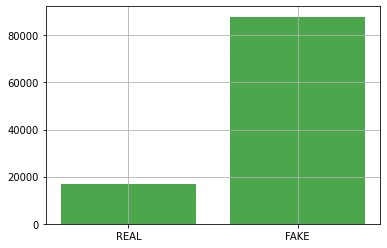

In [9]:
from mlrun import  run_local
gen = run_local(name='deepfake_dataset_gen', handler=handler, 
                project=project_name, artifact_path= os.path.join(artifact_path, 'data'))

In [10]:
prepared_dataset = pd.read_csv(gen.artifact('deepfake_dataset')['target_path'])

print(f'shape of dataset: {prepared_dataset.shape}')
prepared_dataset.head()

shape of dataset: (104890, 2)


,paths,labels
0,training_data/archive/DeepFake00/DeepFake00/vp...,0
1,training_data/archive/DeepFake00/DeepFake00/fz...,0
2,training_data/archive/DeepFake00/DeepFake00/ht...,1
3,training_data/archive/DeepFake00/DeepFake00/fc...,1
4,training_data/archive/DeepFake00/DeepFake00/sp...,1


## Boilerplate code to read images and balance the dataset using the FFHQ face dataset

In [11]:
def read_img(path):
    return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

import random
def get_random_sampling(paths, y, val_paths, val_y, num_train_samples = None, num_val_samples = None):
    real=[]
    fake=[]
    for m,n in zip(paths,y):
        if n==0:
            real.append(m)
        else:
            fake.append(m)
  # fake=random.sample(fake,len(real))
    paths,y=[],[]
    for x in real:
        paths.append(x)
        y.append(0)
    for x in fake:
        paths.append(x)
        y.append(1)

    real=[]
    fake=[]
    
    for m,n in zip(val_paths,val_y):
        if n==0:
            real.append(m)
#           print('found real in val')
        else:
#           print('found fake in val')
            fake.append(m)
    
    
    val_paths,val_y=[],[]
    for x in real:
        val_paths.append(x)
        val_y.append(0)
    for x in fake:
        val_paths.append(x)
        val_y.append(1)

    X=[]
    for img in tqdm(paths):
        X.append(img)
    val_X=[]
    for img in tqdm(val_paths):
        val_X.append(img)

  # Balance with ffhq dataset
    ffhq = os.listdir('training_data/ffhq/thumbnails128x128')
    X_ = []
    for file in tqdm(ffhq):
        path = f'training_data/ffhq/thumbnails128x128/{file}'
        X_.append(path)
    random.shuffle(X_)

    for i in range(64773 - 12130):
        X.append(X_[i])
        y.append(0)
    
    
    del X_[0:64773 - 12130]


    for i in range(6108 - 1258):
        val_X.append(X_[i])
        val_y.append(0)

    X, y = shuffle(X,y)
    val_X, val_y = shuffle(val_X,val_y)
    
    if num_train_samples is not None:
        
        X, y = X[:num_train_samples], y[:num_train_samples]
        
    if num_val_samples is not None:
        
        val_X, val_y = X[:num_val_samples], y[:num_val_samples]

    return X, val_X, y, val_y

In [12]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, x, y, training=True, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.x[idx]
        
        img_numpy = read_img(img_path)
#         print(img_numpy.max(), img_numpy.min())

        if self.transform is not None:
            res = self.transform(image=img_numpy)
            img_numpy = res['image']
            
        img_tensor = torch.tensor(img_numpy).permute(-1,0,1)
        

        labels = self.y[idx]
        return {
            'image': img_tensor,
            'label': labels
        }

## (optional) Clipping training data 

Due to limited computational capabilities, you might not be able to train on the whole dataset. If that's the case then set `num_train_samples` and `num_val_samples` accordingly with small numbers which your machine can handle. 

In [13]:
X, val_X, Y, val_Y = get_random_sampling(
    paths, 
    y, 
    val_paths,
    val_y, 
    num_train_samples= 100, # Set this to None if you want to train on the whole dataset
    num_val_samples= 50     # Set this to None if you want to train on the whole dataset
)

len(X), len(val_X), len(Y), len(val_Y)

100%|██████████| 70000/70000 [00:00<00:00, 4496948.64it/s]


(100, 50, 100, 50)

## Preparing our model

In [14]:
from pytorchcv.model_provider import get_model as ptcv_get_model
model = ptcv_get_model("efficientnet_b4")
model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer
model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))


In [15]:
class Head(torch.nn.Module):
    def __init__(self, in_f, out_f):
        super(Head, self).__init__()

        self.f = nn.Flatten()
        self.l = nn.Linear(in_f, 512)
        self.d = nn.Dropout(0.75)
        self.o = nn.Linear(512, out_f)
        self.b1 = nn.BatchNorm1d(in_f)
        self.b2 = nn.BatchNorm1d(512)
        self.r = nn.ReLU()

    def forward(self, x):
#         print(x.shape)
        x = x.reshape(x.size(0), -1)
        x = self.b1(x)
        x = self.d(x)

        x = self.l(x)
        x = self.r(x)
        x = self.b2(x)
        x = self.d(x)

        out = self.o(x)
        return out

In [16]:
class FCN(torch.nn.Module):
    def __init__(self, base, in_f):
        super(FCN, self).__init__()
        self.base = base
        self.h1 = Head(in_f, 1)
  
    def forward(self, x):
        x = self.base(x)
        return self.h1(x)



## Defining image augmentations 

In [17]:
import albumentations
from albumentations import (
    ShiftScaleRotate, 
    HorizontalFlip, 
    Normalize, 
    RandomBrightnessContrast, 
    MotionBlur, 
    Blur, 
    GaussNoise, 
    JpegCompression
)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = albumentations.Compose([
                                          ShiftScaleRotate(p=0.3, scale_limit=0.25, border_mode=1, rotate_limit=25),
                                          HorizontalFlip(p=0.2),
                                          RandomBrightnessContrast(p=0.3, brightness_limit=0.25, contrast_limit=0.5),
                                          MotionBlur(p=.2),
                                          GaussNoise(p=.2),
                                          JpegCompression(p=.2, quality_lower=50),
                                          Normalize(mean = mean, std = std),
                                          albumentations.augmentations.geometric.resize.Resize(128,128)
])
val_transform = albumentations.Compose([
                                          Normalize(mean = mean, std = std),
                                          albumentations.augmentations.geometric.resize.Resize(128,128)
])

train_dataset = ImageDataset(X, Y, transform=train_transform)
val_dataset = ImageDataset(val_X, val_Y, transform=val_transform)

In [18]:
batch_size = 8
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


## Visualizing training samples 

In [19]:
import torchvision.transforms as transforms
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])                             

def image_tensor_to_rgb(image_tensor, inverse_transform = invTrans ):
    return inverse_transform(image_tensor).permute(1,2,0).cpu().detach()

In [20]:
pair = next(iter(train_loader))

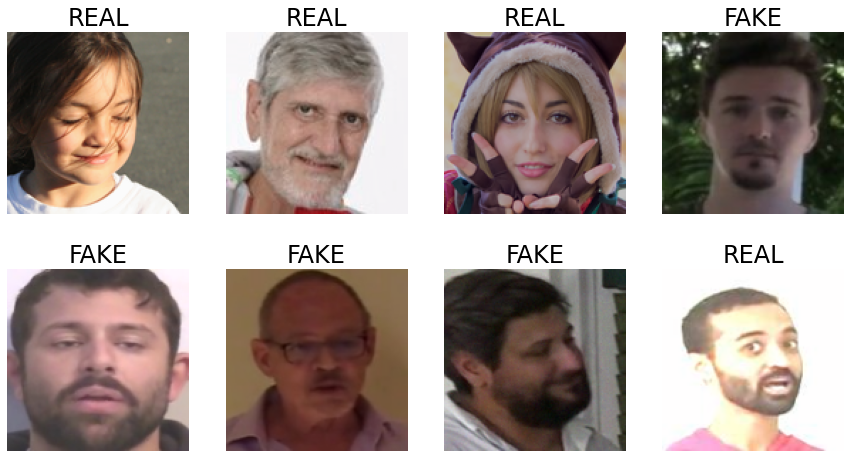

In [21]:
nrow, ncol = 2, 4
fig, ax = plt.subplots(nrow, ncol, figsize=(15,8))

for i in range(8):
    image = image_tensor_to_rgb(pair['image'][i])
    ax.flat[i].imshow(image)
    ax.flat[i].set_title('FAKE' if pair['label'][i].item() == 1 else 'REAL', fontsize = 24)
    ax.flat[i].axis('off')

In [22]:
def criterion(pred1, targets):
    l1 = F.binary_cross_entropy(F.sigmoid(pred1).squeeze(-1), targets)
    return l1

def train_model(model, epoch, optimizer, scheduler, loss ):
    model.train()
    total_loss = 0

    t = tqdm(train_loader, disable = True)
    for i, batch in enumerate(train_loader):
        
        img_batch = batch['image']
        img_batch = img_batch.cuda()

        y_batch = batch['label']
        y_batch = y_batch.cuda().float()

        optimizer.zero_grad()

        out = model(img_batch)
        loss = criterion(out, y_batch)
        

        total_loss += loss
        t.set_description(f'Epoch {epoch+1}, LR: %6f, Loss: %.4f'%(optimizer.state_dict()['param_groups'][0]['lr'],total_loss/(i+1)))

        loss.backward()
        optimizer.step()
        
    scheduler.step(1.)

    return model, total_loss


In [23]:
def get_model():
    model = ptcv_get_model("efficientnet_b4")
    model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer
    model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))
    model = FCN(model, 1792)
    model = model.cuda()
    
    return model

## Hyperparameter grid search with `mlrun`

In [28]:
MAX_LR = 1e-2
MIN_LR = 1e-5
NUM_SAMPLES_LR = 100

MAX_BATCH_SIZE = 64
MIN_BATCH_SIZE = 10

possible_learning_rates = list(np.linspace(MIN_LR, MAX_LR, NUM_SAMPLES_LR))
possible_batch_sizes = [i for i in range(MIN_BATCH_SIZE, MAX_BATCH_SIZE+1, 1)]

In [ ]:
import mlrun

def experiment(context, batch_size, learning_rate):
    
    model = get_model()
    optimizer = torch.optim.AdamW(model.parameters(), lr= learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    model, loss = train_model(model, 0,optimizer, scheduler, loss = criterion)
    
    context.logger.info(f"batch_size = {batch_size} learning_rate = {learning_rate} loss = {loss}")
    context.log_result("loss", loss.item())
    
grid_params = {
    "batch_size": possible_batch_sizes, 
    "learning_rate": possible_learning_rates
}

task = mlrun.new_task("deep-shield-grid-search-hyperparams").with_hyper_params(grid_params, selector="min.loss")
run = mlrun.new_function().run(task, handler=experiment)
## output removed 

In [31]:
run.show()

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
deepfake-shield-mayukh,...4ba2ed,0,Jul 02 11:29:45,completed,deep-shield-grid-search-hyperparams,kind=handlerowner=mayukh,,,,iteration_results


In [36]:
results = pd.read_csv(run.artifact('iteration_results')['target_path'])
results.head()

,state,iter,param.batch_size,param.learning_rate,output.loss
0,completed,1,10,0.000010,12.003371
1,completed,2,11,0.000010,10.489039
2,completed,3,12,0.000010,10.309336
3,completed,4,13,0.000010,10.088676
4,completed,5,10,0.002508,9.996535


In [38]:
best_iter = results[results['output.loss'] == results['output.loss'].min()]

ideal_params = {
    'learning_rate': best_iter['param.learning_rate'].values[0],
    'batch_size': best_iter['param.batch_size'].values[0]
}

ideal_params

{'learning_rate': 0.002508, 'batch_size': 39}

In [165]:

def evaluate_model(model, val_loader):
    model.eval()
    pred = []
    real = []
    with torch.no_grad():
        for batch in val_loader:
        
            img_batch, y_batch = batch['image'].cuda().float(), batch['label'].cuda().float()

            o1 = model(img_batch)
            
            for j in o1:
                pred.append(F.sigmoid(j))
                
            for i in y_batch:
                real.append(i.data.cpu())
    
    pred = [p.data.cpu().numpy() for p in pred]
    pred = [np.round(p) for p in pred]
    pred = np.array(pred)
    acc = sklearn.metrics.recall_score(real, pred, average='macro')

    return acc

In [166]:
import gc 

def train_n_epochs(model, num_epochs , train_loader, val_loader, checkpoint_name = 'model.pth', lr = 0.001, loss = None, context = None):
    
    best_acc = 0.
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        gc.collect()

        model, loss = train_model(model, epoch, optimizer, scheduler, loss = loss)

        acc = evaluate_model(model, val_loader)
        

        if acc > best_acc:
            best_acc = acc
            print(f'Saving best model: {checkpoint_name}')
            torch.save(model.state_dict(), checkpoint_name)
            
        if context is not None:
            context.logger.info(f'epoch: {epoch+1} current acc: {round(acc, 4)} best acc: {round(best_acc, 4)}')
            
    return model

In [169]:
def train_model_auto(context, num_epochs, hyperparams, checkpoint_name):
    train_n_epochs(
        model = get_model(),
        num_epochs = num_epochs,
        train_loader= train_loader,
        val_loader=  val_loader,
        lr = hyperparams['learning_rate'],
        loss = criterion,
        checkpoint_name = checkpoint_name,
        context = context
    )
    

## Training the model with `mlrun`

In [203]:
train_loader = DataLoader(dataset=train_dataset, batch_size=ideal_params['batch_size'], shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size= 10, shuffle=False, num_workers=0)


In [207]:
PARAMS = {
        'num_epochs':21,
        'hyperparams': ideal_params,
        'checkpoint_name': 'model.pt'
    
    }

TRAIN_RUN = run_local(
    name = 'train_model_auto',
    handler = train_model_auto,
    params = PARAMS
)

> 2021-07-02 13:55:46,765 [info] starting run train_model_auto uid=4449252465f24ed0a41666418b4026dd DB=./
Saving best model: model.pt
> 2021-07-02 13:55:49,380 [info] epoch: 1 current acc: 0.5 best acc: 0.5
> 2021-07-02 13:55:51,124 [info] epoch: 2 current acc: 0.5 best acc: 0.5
> 2021-07-02 13:55:52,939 [info] epoch: 3 current acc: 0.375 best acc: 0.5
Saving best model: model.pt
> 2021-07-02 13:55:55,202 [info] epoch: 4 current acc: 0.7708 best acc: 0.7708
Saving best model: model.pt
> 2021-07-02 13:55:57,685 [info] epoch: 5 current acc: 0.7933 best acc: 0.7933
Saving best model: model.pt
> 2021-07-02 13:56:01,891 [info] epoch: 6 current acc: 0.7997 best acc: 0.7997
Epoch     7: reducing learning rate of group 0 to 1.7553e-03.
Saving best model: model.pt
> 2021-07-02 13:56:04,419 [info] epoch: 7 current acc: 0.8574 best acc: 0.8574
> 2021-07-02 13:56:06,219 [info] epoch: 8 current acc: 0.8349 best acc: 0.8574
> 2021-07-02 13:56:08,087 [info] epoch: 9 current acc: 0.8542 best acc: 0.85

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
deepfake-shield-mayukh,...4026dd,0,Jul 02 08:25:47,completed,train_model_auto,kind=handlerowner=mayukhhost=leopard,,"num_epochs=21hyperparams={'learning_rate': 0.0025075, 'batch_size': 8}checkpoint_name=model.pt",,


to track results use .show() or .logs() or in CLI: 
!mlrun get run 4449252465f24ed0a41666418b4026dd --project deepfake-shield-mayukh , !mlrun logs 4449252465f24ed0a41666418b4026dd --project deepfake-shield-mayukh
> 2021-07-02 13:56:30,991 [info] run executed, status=completed


In [216]:
best_model = get_model()
best_model.load_state_dict(torch.load(PARAMS['checkpoint_name']))

acc = evaluate_model(model = best_model.cuda(), val_loader = val_loader)
print(f'final accuracy: {acc}')

final accuracy: 0.9791666666666667
